**Import Libraries**

In [27]:
#Normal distribution functions
from scipy.stats import norm

# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Error Metrics
from sklearn.metrics import mean_squared_error

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

**Black Scholes Formula**

In [28]:
true_alpha = 0.2
true_beta = 0.2
true_sigma0 = 0.3
interest = 0.1

def vol(moneyness, time):
    return true_sigma0 + true_alpha * time + true_beta * np.square(moneyness - 1)

def call_option_price(moneyness, time, option_vol):
    d1=(np.log(1/moneyness)+(interest + np.square(option_vol))*time)/(option_vol*np.sqrt(time))
    d2=(np.log(1/moneyness)+(interest - np.square(option_vol))*time)/(option_vol*np.sqrt(time))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(- interest * time) * N_d2

**Generating Data**

In [29]:
N = 10000

moneys = 1+0.2*np.random.randn(N)
times = np.random.random(N)
volatility = np.array([vol(k,t) for k,t in zip(moneys, times)])
prices = np.array([call_option_price(k,t,sig) for k,t,sig in zip(moneys, times, volatility)])
print('moneys', moneys)
print('times', times)
print('volatility', volatility)
print('prices', prices)

moneys [1.27026584 0.69639566 1.01101649 ... 1.10583088 1.23534935 0.99448386]
times [0.76958228 0.93221025 0.89720878 ... 0.36251987 0.25878299 0.70635322]
volatility [0.46852518 0.50487717 0.47946603 ... 0.37474401 0.36283446 0.44127673]
prices [0.25926839 0.49587445 0.37490049 ... 0.15126332 0.06502195 0.31534739]


**Visualize**

[[1.27026584 0.76958228 0.46852518]
 [0.69639566 0.93221025 0.50487717]
 [1.01101649 0.89720878 0.47946603]
 ...
 [1.10583088 0.36251987 0.37474401]
 [1.23534935 0.25878299 0.36283446]
 [0.99448386 0.70635322 0.44127673]]

[0.25926839 0.49587445 0.37490049 ... 0.15126332 0.06502195 0.31534739]

      Price  Moneyness      Time  Volatility
0  0.259268   1.270266  0.769582    0.468525
1  0.495874   0.696396  0.932210    0.504877
2  0.374900   1.011016  0.897209    0.479466
3  0.314695   0.689199  0.056661    0.330652
4  0.296680   0.917449  0.569556    0.415274


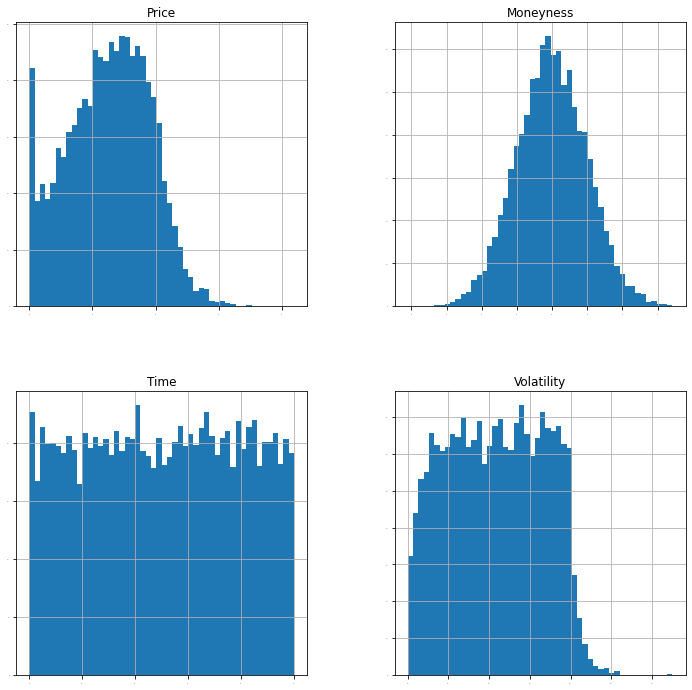

In [30]:
Y = prices
X = np.concatenate([moneys.reshape(-1,1), times.reshape(-1,1), volatility.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Volatility'])
print(X)
print()
print(Y)
print()
print(dataset.head())
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

**Train Test Split**

In [31]:
#train-test = 80-20
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
print(train_size)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

8000


**Models and K-fold Analysis**

In [32]:
models = []

#Linear Models and Regression Trees
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#Neural Network Predictor (Multi Layer Perceptron)
models.append(('MLP', MLPRegressor()))

# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

num_folds = 10
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000358 (0.000030) 0.000357 0.000334
LASSO: 0.017056 (0.000512) 0.017048 0.016445
EN: 0.017056 (0.000512) 0.017048 0.016445
KNN: 0.000015 (0.000018) 0.000009 0.000016
DT: 0.000020 (0.000011) 0.000000 0.000016
SVR: 0.001636 (0.000114) 0.001698 0.001675
MLP: 0.000063 (0.000035) 0.000061 0.000058
ABR: 0.001070 (0.000047) 0.001068 0.001128
GBR: 0.000038 (0.000011) 0.000028 0.000036
RFR: 0.000007 (0.000011) 0.000001 0.000004
ETR: 0.000005 (0.000013) 0.000000 0.000001


**Results**

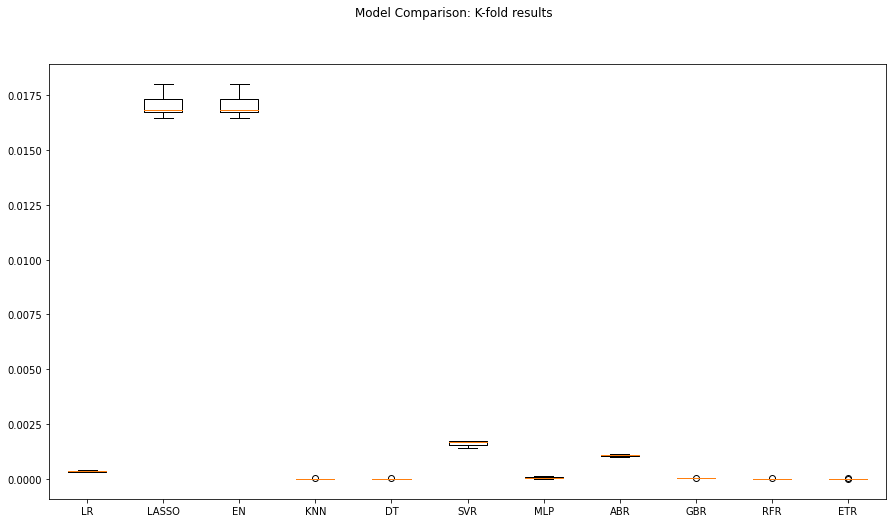

In [33]:
fig = pyplot.figure()
fig.suptitle('Model Comparison: K-fold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

**Remove LASSO and ElasticNet**

LR:   0.000357 0.000334
KNN:   0.000009 0.000016
DT:   0.000000 0.000016
SVR:   0.001698 0.001675
MLP:   0.000061 0.000058
ABR:   0.001068 0.001128
GBR:   0.000028 0.000036
RFR:   0.000001 0.000004
ETR:   0.000000 0.000001


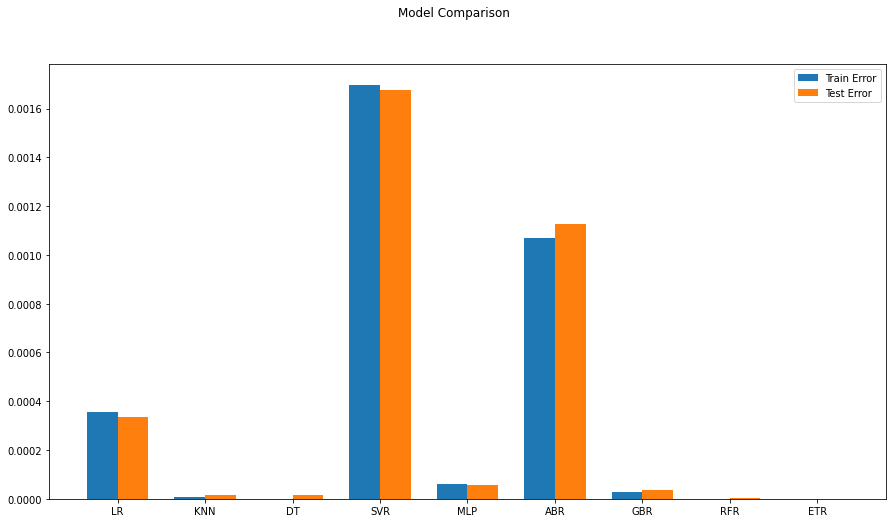

In [34]:
# compare algorithms
fig = pyplot.figure()
train = train_results[0:1] + train_results[3:]
test = test_results[0:1] + test_results[3:]
if 'LASSO' in names:
  names.remove('LASSO')
if 'EN' in names:
  names.remove('EN')

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
for i in range(len(train)):
  p = "%s: %10f %f" % (names[i], train[i], test[i])
  print(p)
pyplot.show()

**Improving MLP using GridSearchCV**

In [35]:
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=MLPRegressor(), param_grid=param_grid, scoring=scoring, cv=kfold)
mlp = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (mlp.best_score_, mlp.best_params_))
print()
#improved MLP
predictions = mlp.predict(X_test)
print(mean_squared_error(Y_test, predictions))

Best: -0.000068 using {'hidden_layer_sizes': (20, 30, 20)}

6.56856199531193e-05


**Additional analysis: Removing volatility data**

In [36]:
X = np.concatenate([moneys.reshape(-1,1), times.reshape(-1,1)], axis=1)
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

models = []
#Linear Models and Regression Trees
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#Neural Network Predictor (Multi Layer Perceptron)
models.append(('MLP', MLPRegressor()))

# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))


num_folds = 10
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 


names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the better
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000772 (0.000098) 0.000771 0.000709
KNN: 0.000015 (0.000018) 0.000009 0.000016
DT: 0.000019 (0.000010) 0.000000 0.000034
SVR: 0.001768 (0.000089) 0.001769 0.001786
MLP: 0.000098 (0.000049) 0.000022 0.000024
ABR: 0.001094 (0.000050) 0.001092 0.001152
GBR: 0.000034 (0.000006) 0.000027 0.000035
RFR: 0.000007 (0.000010) 0.000001 0.000004
ETR: 0.000006 (0.000015) 0.000000 0.000001


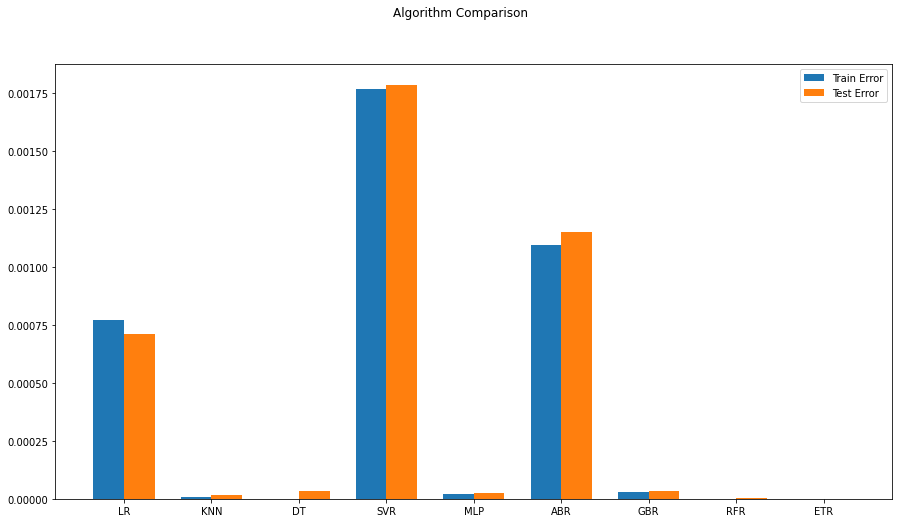

In [37]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

**Additional analysis: Varying the parameters without volatility data**

alpha 0.2 beta 0.2 sigma0 0.3 interest 0.1 N 10000
LR: 0.000808 0.000742
KNN: 0.000007 0.000027
DT: 0.000000 0.000026
SVR: 0.002030 0.002068
MLP: 0.000035 0.000037
ABR: 0.000989 0.001039
GBR: 0.000025 0.000036
RFR: 0.000001 0.000014
ETR: 0.000000 0.000011


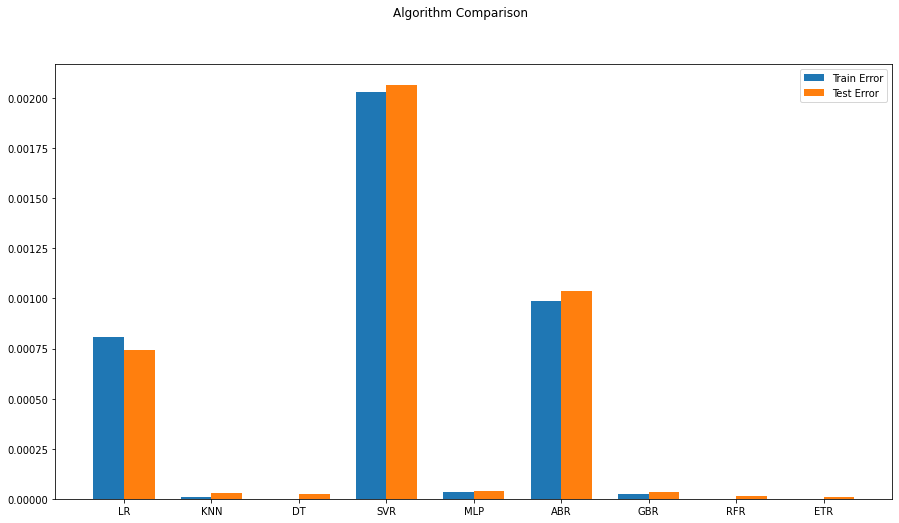

alpha 0.4 beta 0.2 sigma0 0.3 interest 0.1 N 10000
LR: 0.000819 0.000903
KNN: 0.000006 0.000016
DT: 0.000000 0.000021
SVR: 0.001391 0.001433
MLP: 0.000066 0.000080
ABR: 0.001186 0.001194
GBR: 0.000031 0.000039
RFR: 0.000001 0.000005
ETR: 0.000000 0.000005


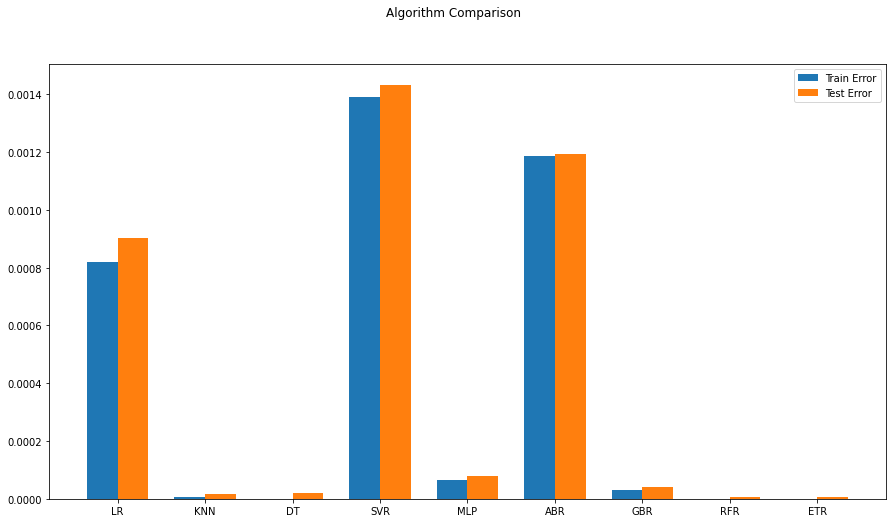

alpha 0.6 beta 0.2 sigma0 0.3 interest 0.1 N 10000
LR: 0.000938 0.000911
KNN: 0.000010 0.000015
DT: 0.000000 0.000030
SVR: 0.001630 0.001610
MLP: 0.000041 0.000029
ABR: 0.001333 0.001373
GBR: 0.000033 0.000042
RFR: 0.000001 0.000016
ETR: 0.000000 0.000012


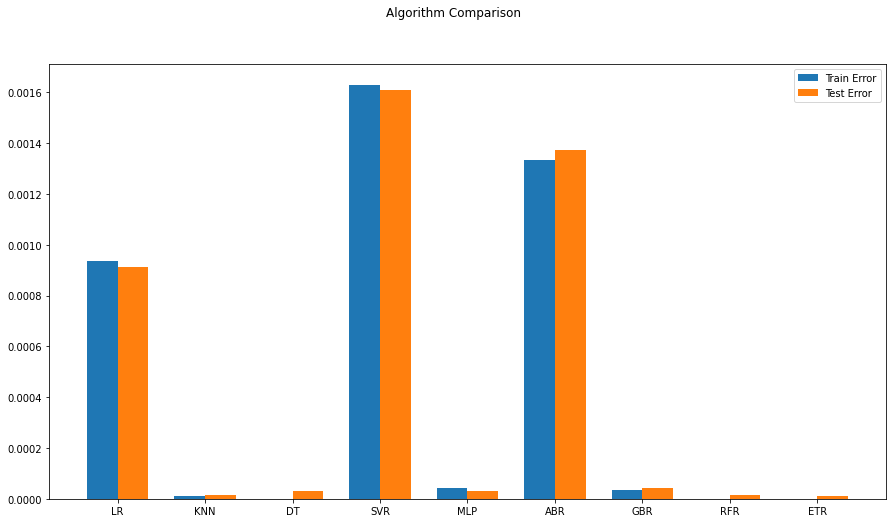

alpha 0.8 beta 0.2 sigma0 0.3 interest 0.1 N 10000
LR: 0.001100 0.000911
KNN: 0.000008 0.000009
DT: 0.000000 0.000021
SVR: 0.001190 0.001126
MLP: 0.000084 0.000064
ABR: 0.001377 0.001362
GBR: 0.000032 0.000039
RFR: 0.000001 0.000004
ETR: 0.000000 0.000001


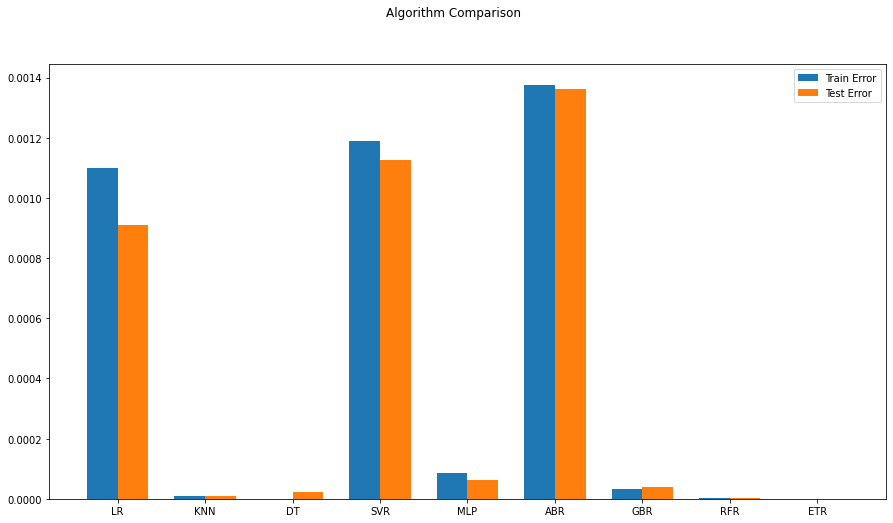

alpha 1.0 beta 0.2 sigma0 0.3 interest 0.1 N 10000
LR: 0.001104 0.001109
KNN: 0.000008 0.000010
DT: 0.000000 0.000022
SVR: 0.001130 0.001114
MLP: 0.000086 0.000084
ABR: 0.001369 0.001368
GBR: 0.000027 0.000034
RFR: 0.000001 0.000004
ETR: 0.000000 0.000001


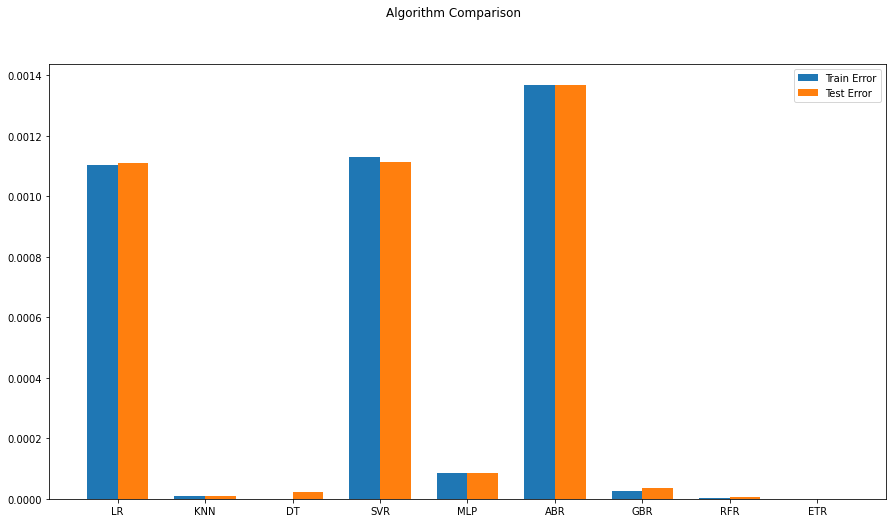

alpha 0.2 beta 0.2 sigma0 0.3 interest 0.1 N 10000
LR: 0.000784 0.000789
KNN: 0.000010 0.000010
DT: 0.000000 0.000021
SVR: 0.002594 0.002567
MLP: 0.000036 0.000036
ABR: 0.001046 0.001069
GBR: 0.000025 0.000031
RFR: 0.000001 0.000004
ETR: 0.000000 0.000001


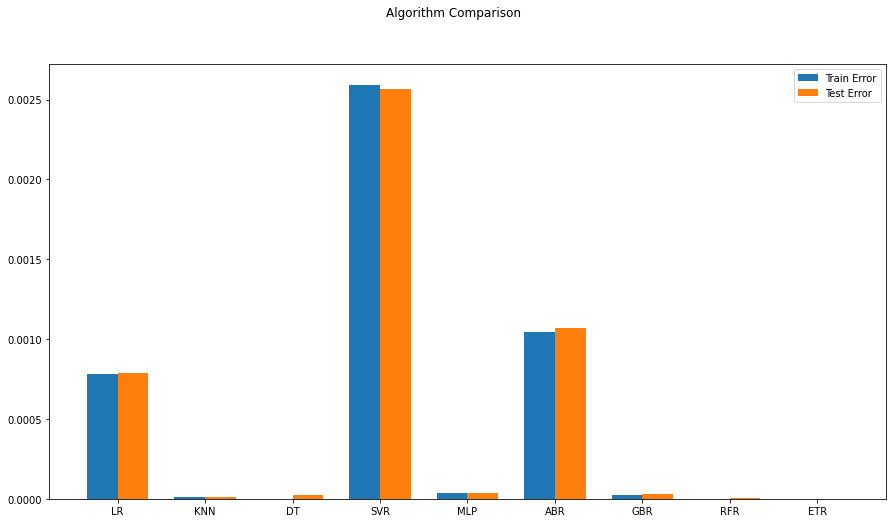

alpha 0.2 beta 0.4 sigma0 0.3 interest 0.1 N 10000
LR: 0.000925 0.000952
KNN: 0.000007 0.000014
DT: 0.000000 0.000017
SVR: 0.002061 0.002080
MLP: 0.000025 0.000027
ABR: 0.000977 0.001025
GBR: 0.000027 0.000036
RFR: 0.000001 0.000006
ETR: 0.000000 0.000003


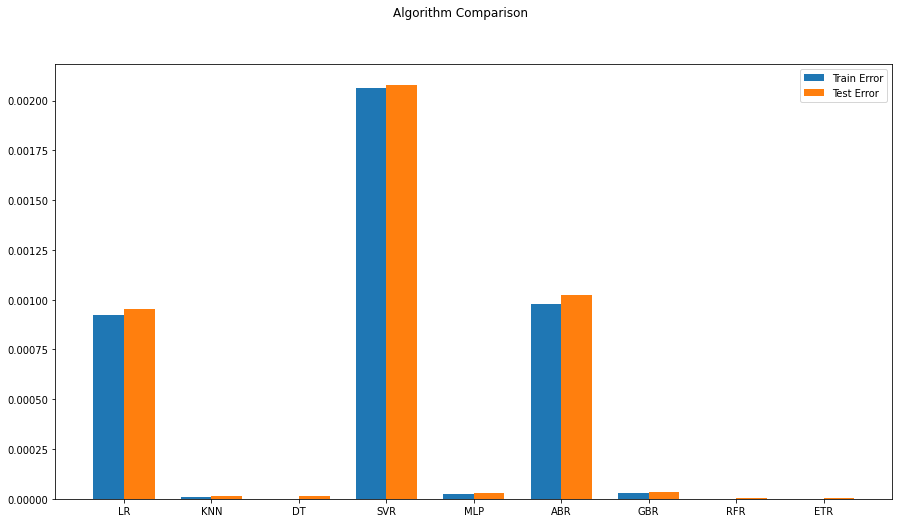

alpha 0.2 beta 0.6 sigma0 0.3 interest 0.1 N 10000
LR: 0.001198 0.001249
KNN: 0.000005 0.000048
DT: 0.000000 0.000059
SVR: 0.002535 0.002573
MLP: 0.000037 0.000043
ABR: 0.000922 0.001016
GBR: 0.000027 0.000071
RFR: 0.000001 0.000053
ETR: 0.000000 0.000043


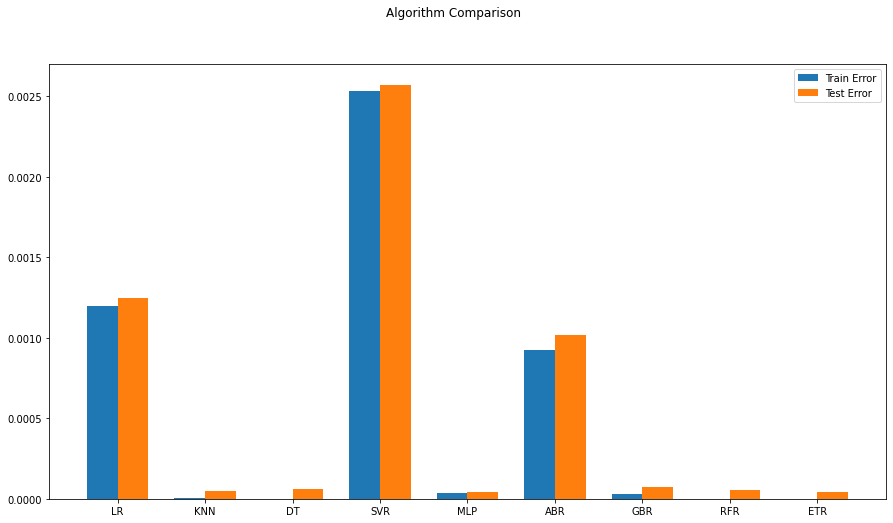

alpha 0.2 beta 0.8 sigma0 0.3 interest 0.1 N 10000
LR: 0.001275 0.001487
KNN: 0.000007 0.000018
DT: 0.000000 0.000024
SVR: 0.002920 0.002892
MLP: 0.000091 0.000103
ABR: 0.001194 0.001177
GBR: 0.000025 0.000035
RFR: 0.000001 0.000008
ETR: 0.000000 0.000003


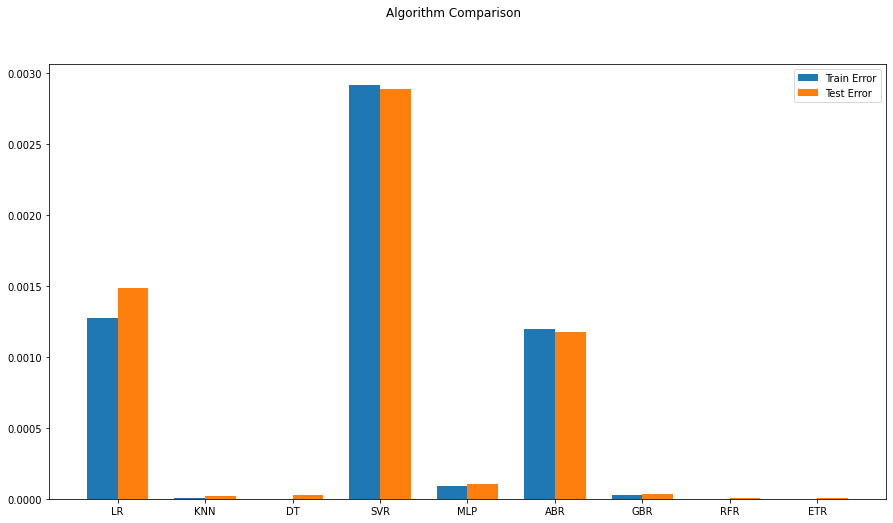

alpha 0.2 beta 1.0 sigma0 0.3 interest 0.1 N 10000
LR: 0.001678 0.001612
KNN: 0.000009 0.000012
DT: 0.000000 0.000019
SVR: 0.002828 0.002814
MLP: 0.000129 0.000115
ABR: 0.001211 0.001232
GBR: 0.000030 0.000041
RFR: 0.000001 0.000008
ETR: 0.000000 0.000004


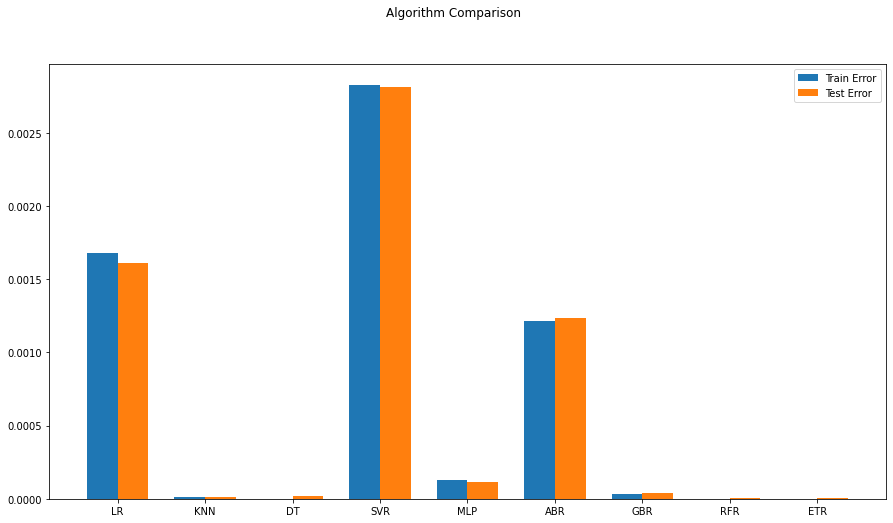

alpha 0.2 beta 0.2 sigma0 0.2 interest 0.1 N 10000
LR: 0.001046 0.001075
KNN: 0.000007 0.000007
DT: 0.000000 0.000014
SVR: 0.004862 0.004938
MLP: 0.000035 0.000030
ABR: 0.000863 0.000861
GBR: 0.000020 0.000026
RFR: 0.000000 0.000003
ETR: 0.000000 0.000000


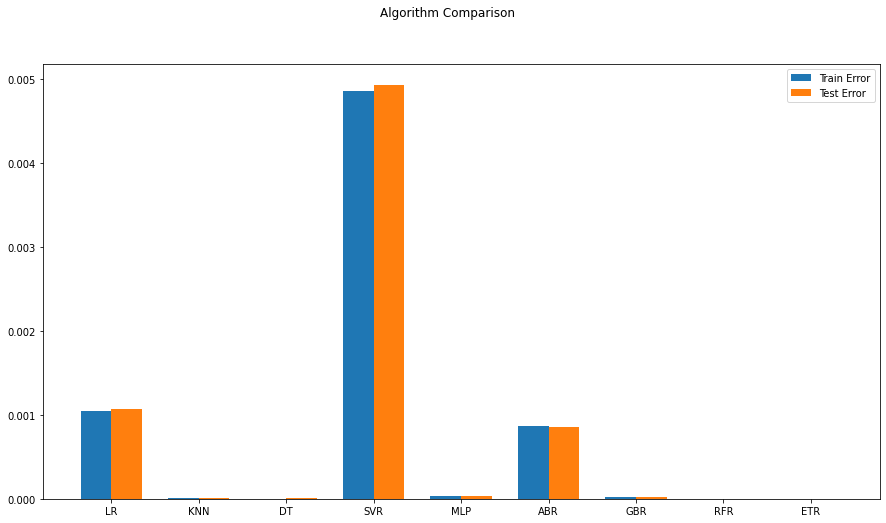

alpha 0.2 beta 0.2 sigma0 0.4 interest 0.1 N 10000
LR: 0.000733 0.000658
KNN: 0.000010 0.000017
DT: 0.000000 0.000020
SVR: 0.000983 0.001020
MLP: 0.000054 0.000051
ABR: 0.001196 0.001278
GBR: 0.000024 0.000035
RFR: 0.000001 0.000008
ETR: 0.000000 0.000004


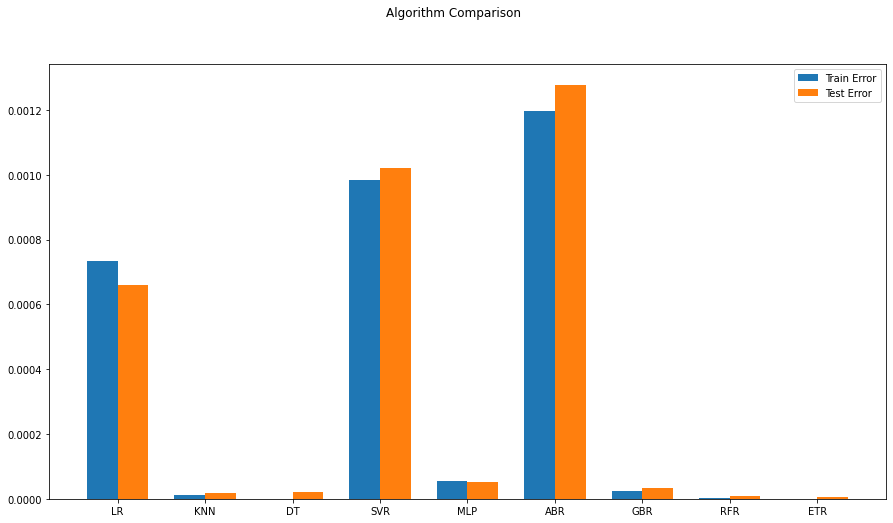

alpha 0.2 beta 0.2 sigma0 0.6 interest 0.1 N 10000
LR: 0.000826 0.000984
KNN: 0.000008 0.000021
DT: 0.000000 0.000030
SVR: 0.002710 0.002732
MLP: 0.000092 0.000140
ABR: 0.001090 0.001119
GBR: 0.000023 0.000034
RFR: 0.000001 0.000013
ETR: 0.000000 0.000010


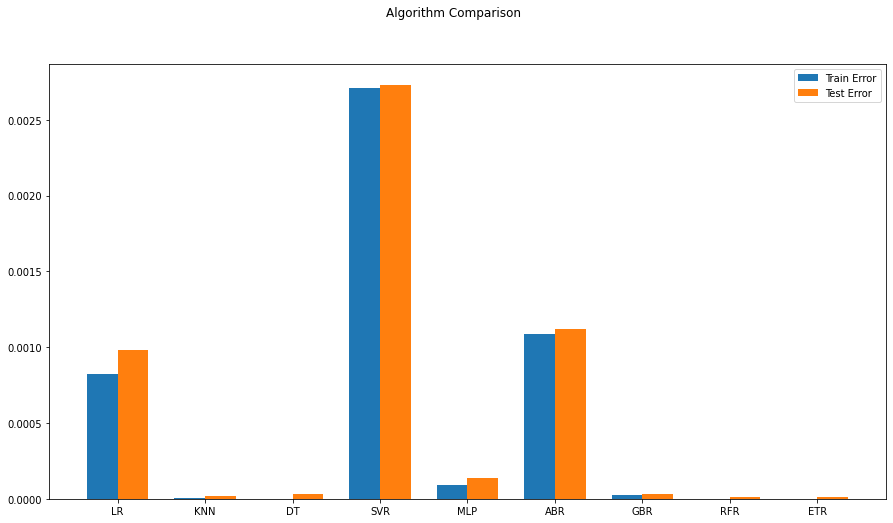

alpha 0.2 beta 0.2 sigma0 0.8 interest 0.1 N 10000
LR: 0.001310 0.001267
KNN: 0.000008 0.000013
DT: 0.000000 0.000023
SVR: 0.003858 0.003883
MLP: 0.000141 0.000130
ABR: 0.001025 0.001049
GBR: 0.000022 0.000029
RFR: 0.000001 0.000008
ETR: 0.000000 0.000004


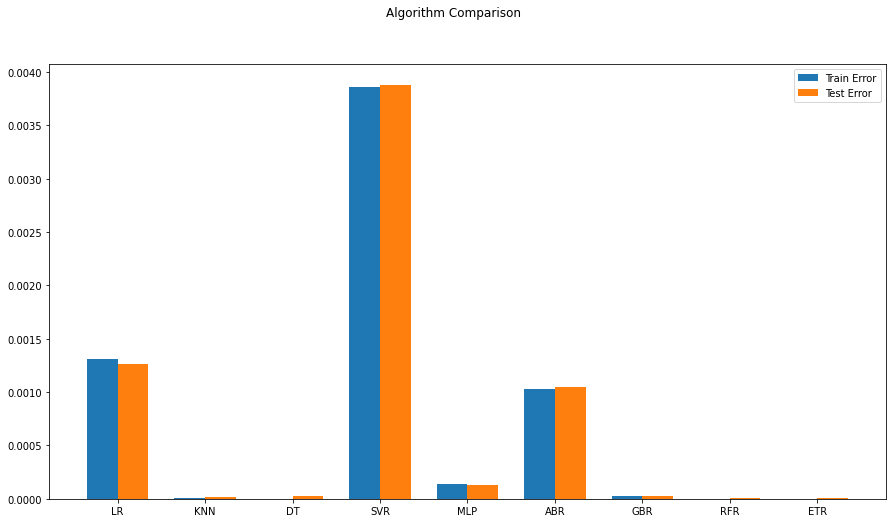

alpha 0.2 beta 0.2 sigma0 1.0 interest 0.1 N 10000
LR: 0.002103 0.002168
KNN: 0.000011 0.000013
DT: 0.000000 0.000024
SVR: 0.003258 0.003427
MLP: 0.000184 0.000200
ABR: 0.001054 0.001037
GBR: 0.000021 0.000027
RFR: 0.000002 0.000005
ETR: 0.000000 0.000001


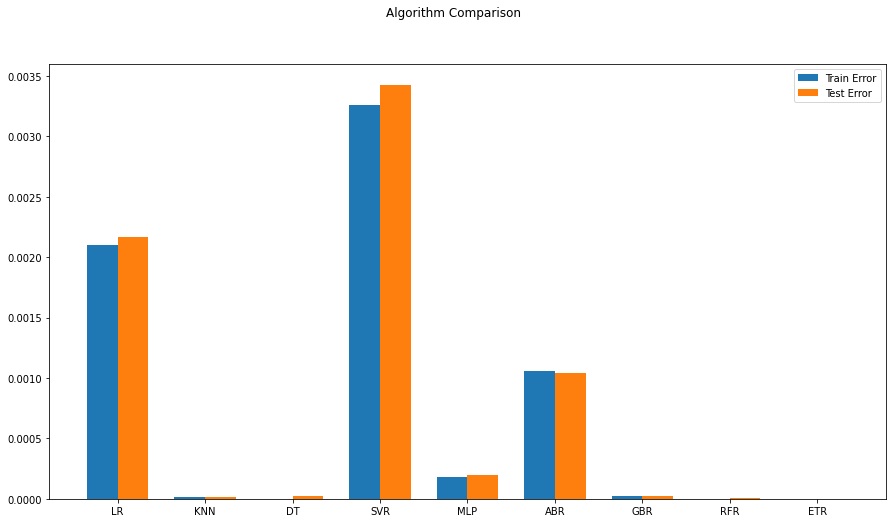

alpha 0.2 beta 0.2 sigma0 0.3 interest 0.2 N 10000
LR: 0.000816 0.000827
KNN: 0.000008 0.000007
DT: 0.000000 0.000016
SVR: 0.001249 0.001213
MLP: 0.000065 0.000064
ABR: 0.001109 0.001135
GBR: 0.000027 0.000035
RFR: 0.000001 0.000003
ETR: 0.000000 0.000001


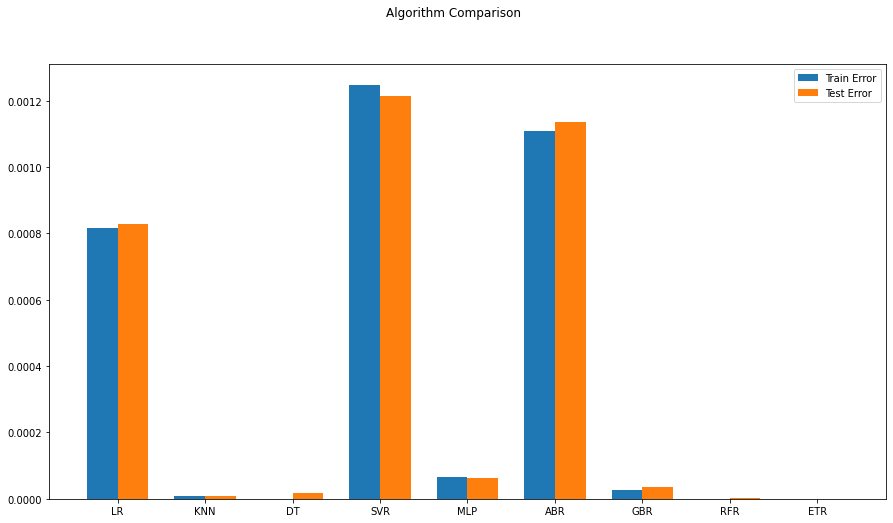

alpha 0.2 beta 0.2 sigma0 0.3 interest 0.4 N 10000
LR: 0.000960 0.000983
KNN: 0.000008 0.000012
DT: 0.000000 0.000019
SVR: 0.000686 0.000674
MLP: 0.000046 0.000050
ABR: 0.001204 0.001240
GBR: 0.000028 0.000037
RFR: 0.000001 0.000005
ETR: 0.000000 0.000002


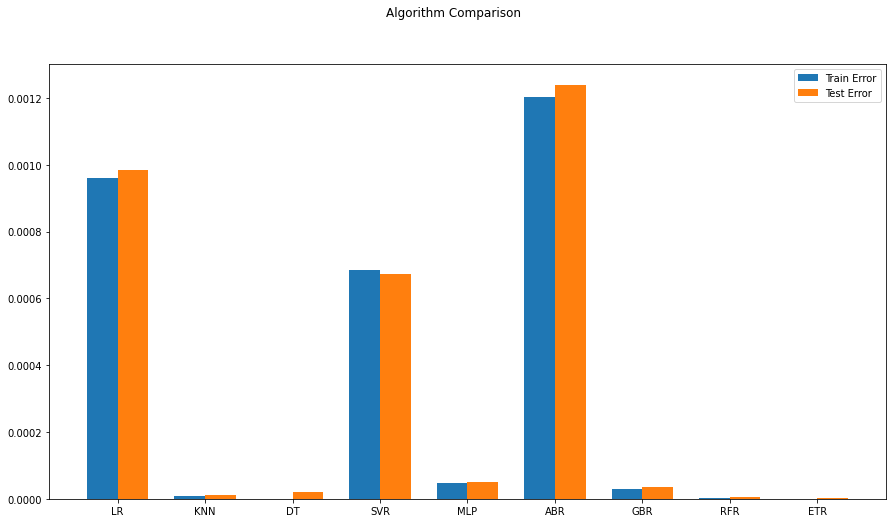

alpha 0.2 beta 0.2 sigma0 0.3 interest 0.6 N 10000
LR: 0.001078 0.001046
KNN: 0.000008 0.000009
DT: 0.000000 0.000023
SVR: 0.001265 0.001138
MLP: 0.000080 0.000083
ABR: 0.001481 0.001474
GBR: 0.000031 0.000038
RFR: 0.000001 0.000005
ETR: 0.000000 0.000001


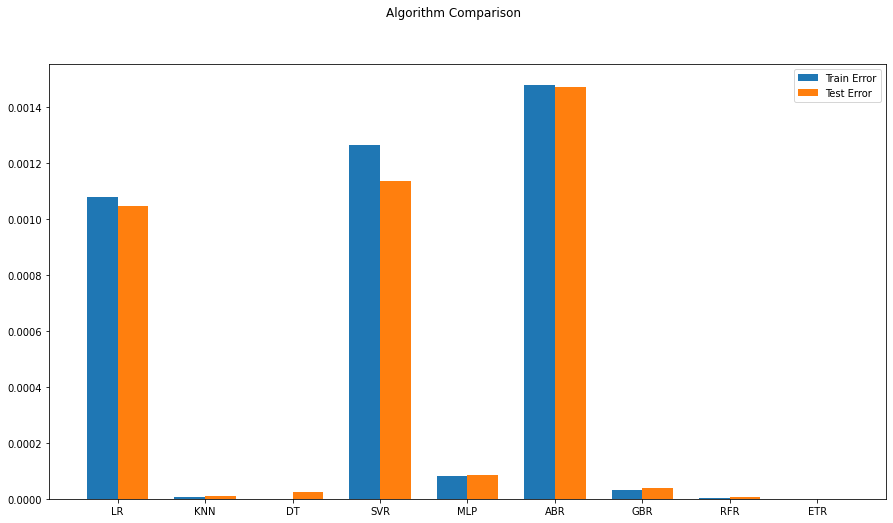

alpha 0.2 beta 0.2 sigma0 0.3 interest 0.8 N 10000
LR: 0.001120 0.001187
KNN: 0.000009 0.000010
DT: 0.000000 0.000026
SVR: 0.002021 0.002049
MLP: 0.000698 0.000723
ABR: 0.001490 0.001598
GBR: 0.000034 0.000041
RFR: 0.000002 0.000007
ETR: 0.000000 0.000002


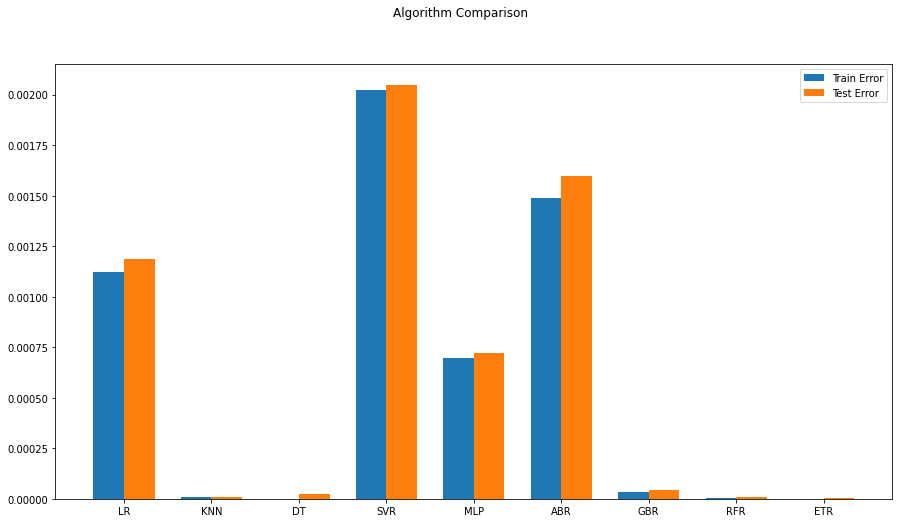

alpha 0.2 beta 0.2 sigma0 0.3 interest 1.0 N 10000
LR: 0.001210 0.001238
KNN: 0.000007 0.000022
DT: 0.000000 0.000034
SVR: 0.002058 0.002174
MLP: 0.000172 0.000195
ABR: 0.001642 0.001786
GBR: 0.000033 0.000048
RFR: 0.000001 0.000012
ETR: 0.000000 0.000009


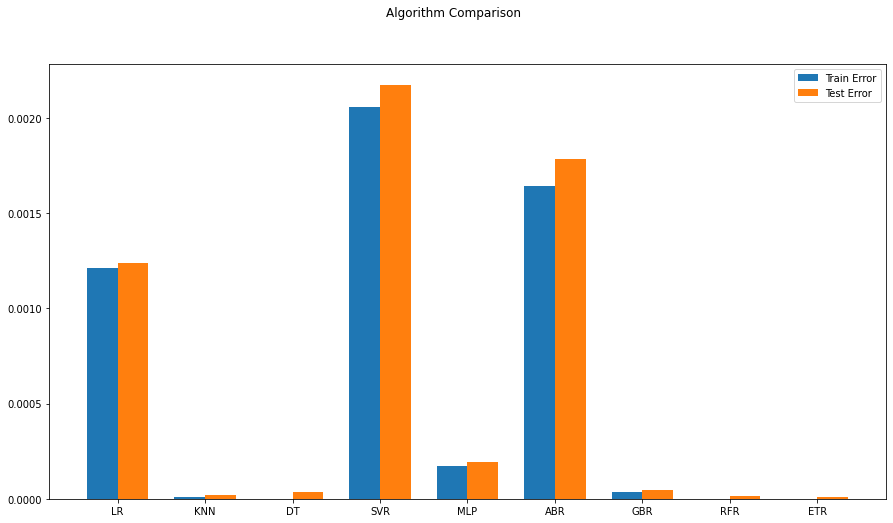

alpha 0.2 beta 0.2 sigma0 0.3 interest 0.1 N 20000
LR: 0.000767 0.000843
KNN: 0.000005 0.000004
DT: 0.000000 0.000008
SVR: 0.002605 0.002611
MLP: 0.000029 0.000030
ABR: 0.001058 0.001040
GBR: 0.000023 0.000026
RFR: 0.000001 0.000002
ETR: 0.000000 0.000001


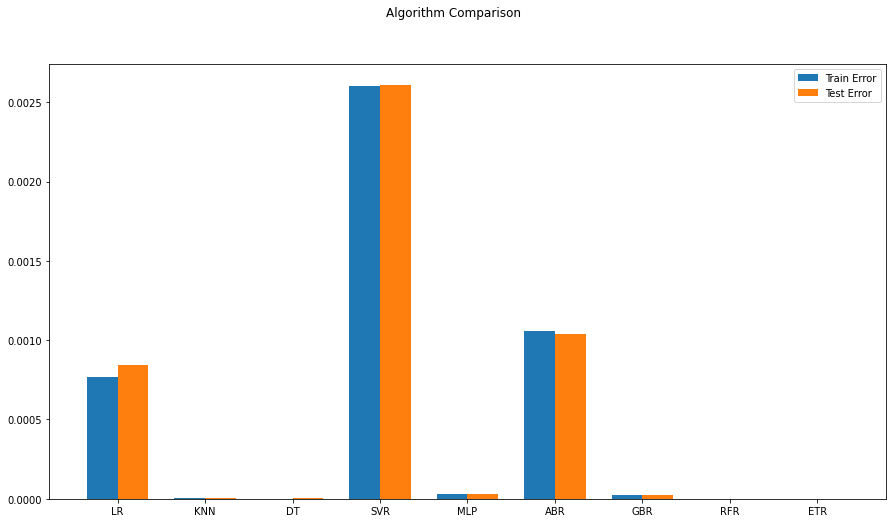

alpha 0.2 beta 0.2 sigma0 0.3 interest 0.1 N 30000
LR: 0.000799 0.000809
KNN: 0.000002 0.000003
DT: 0.000000 0.000005
SVR: 0.002467 0.002465
MLP: 0.000009 0.000009
ABR: 0.001038 0.001060
GBR: 0.000026 0.000028
RFR: 0.000000 0.000001
ETR: 0.000000 0.000000


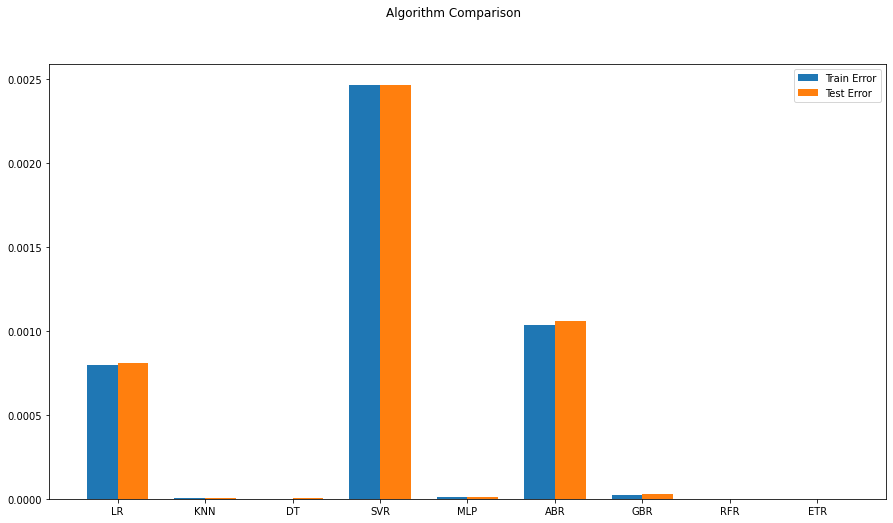

alpha 0.2 beta 0.2 sigma0 0.3 interest 0.1 N 40000
LR: 0.000816 0.000774
KNN: 0.000002 0.000002
DT: 0.000000 0.000004
SVR: 0.001935 0.001874
MLP: 0.000011 0.000010
ABR: 0.001027 0.001016
GBR: 0.000024 0.000027
RFR: 0.000000 0.000001
ETR: 0.000000 0.000000


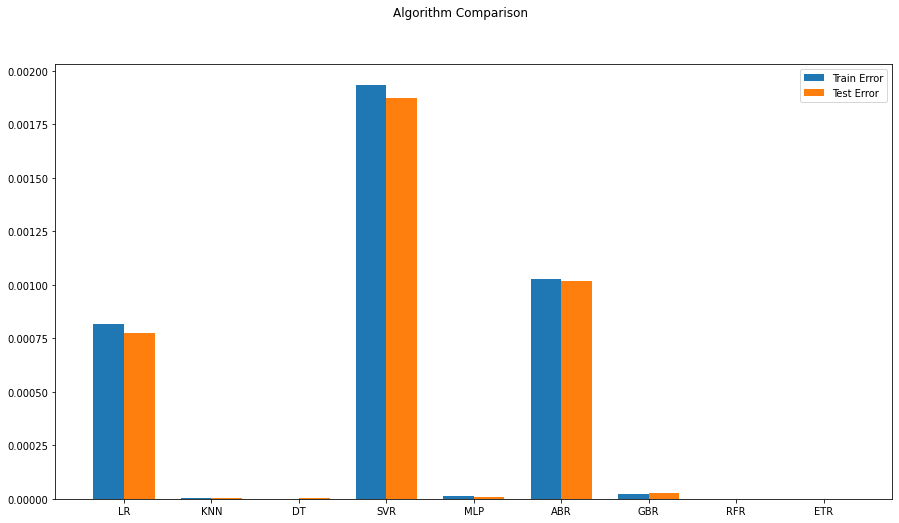

alpha 0.2 beta 0.2 sigma0 0.3 interest 0.1 N 50000
LR: 0.000794 0.000827
KNN: 0.000001 0.000004
DT: 0.000000 0.000003
SVR: 0.002298 0.002302
MLP: 0.000010 0.000009
ABR: 0.001056 0.001079
GBR: 0.000024 0.000027
RFR: 0.000000 0.000001
ETR: 0.000000 0.000001


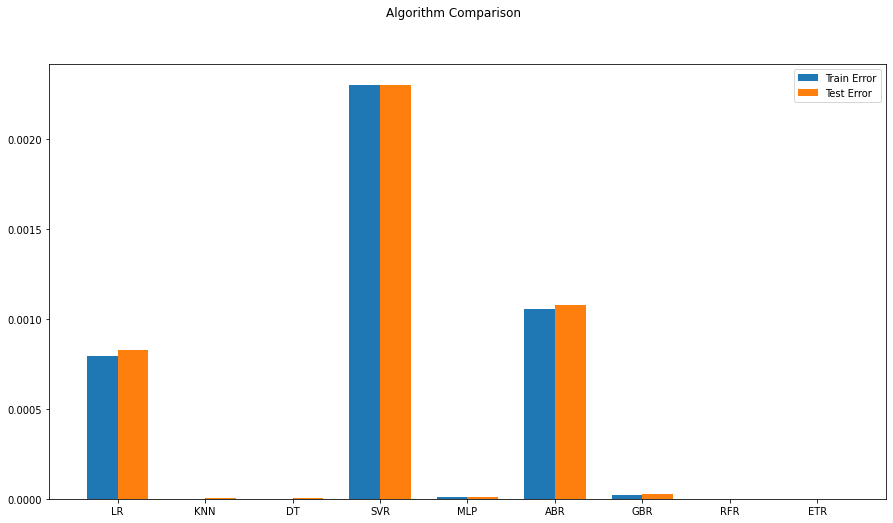

In [38]:
true_alpha = 0.2
true_beta = 0.2
true_sigma0 = 0.3
interest = 0.1
N = 10000
def change_parameters():
    moneys = 1+0.2*np.random.randn(N)
    times = np.random.random(N)
    volatility = np.array([vol(k,t) for k,t in zip(moneys, times)])
    prices = np.array([call_option_price(k,t,sig) for k,t,sig in zip(moneys, times, volatility)])
    Y = prices
    X = np.concatenate([moneys.reshape(-1,1), times.reshape(-1,1)], axis=1)
    validation_size = 0.2
    print('alpha', true_alpha, 'beta', true_beta, 'sigma0', true_sigma0, 'interest', interest, 'N', N)
    train_size = int(len(X) * (1-validation_size))
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]
    models = []
    #Linear Models and Regression Trees
    models.append(('LR', LinearRegression()))
    models.append(('KNN', KNeighborsRegressor()))
    models.append(('DT', DecisionTreeRegressor()))
    models.append(('SVR', SVR()))
    #Neural Network Predictor (Multi Layer Perceptron)
    models.append(('MLP', MLPRegressor()))
    # Boosting methods
    models.append(('ABR', AdaBoostRegressor()))
    models.append(('GBR', GradientBoostingRegressor()))
    # Bagging methods
    models.append(('RFR', RandomForestRegressor()))
    models.append(('ETR', ExtraTreesRegressor()))
    num_folds = 10
    # scikit is moving away from mean_squared_error. 
    # In order to avoid confusion, and to allow comparison with other models, we invert the final scores
    scoring = 'neg_mean_squared_error' 
    names = []
    test_results = []
    train_results = []
    for name, model in models:
        names.append(name)
        # Full Training period
        res = model.fit(X_train, Y_train)
        train_result = mean_squared_error(res.predict(X_train), Y_train)
        train_results.append(train_result)
        # Test results
        test_result = mean_squared_error(res.predict(X_test), Y_test)
        test_results.append(test_result)
        
        msg = "%s: %f %f" % (name, train_result, test_result)
        print(msg)
    # compare algorithms
    fig = pyplot.figure()

    ind = np.arange(len(names))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
    pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
    fig.set_size_inches(15,8)
    pyplot.legend()
    ax.set_xticks(ind)
    ax.set_xticklabels(names)
    pyplot.show()

arr = [0.2, 0.4, 0.6, 0.8, 1.0]
for true_alpha in arr:
    change_parameters()
true_alpha = 0.2
for true_beta in arr:
    change_parameters()
true_beta = 0.2
for true_sigma0 in arr:
    change_parameters()
true_sigma0 = 0.3
for interest in arr:
    change_parameters()
interest = 0.1
for N in [20000, 30000, 40000, 50000]:
    change_parameters()